<a href="https://colab.research.google.com/github/saurabhlalsaxena/Perplexity-Clone-v0.1/blob/main/Austin_LangChain_Perpexity_Clone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [24]:
!pip install -q -U langchain-cli langchain langchain_core langgraph langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install -q langchainhub

In [3]:
!pip install -q openai langchain_openai langchain-anthropic langchain-mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.9/866.9 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00


In [4]:
!pip install -q duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.8 MB/s eta 0:00:00


In [5]:
!pip install -q html2text beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
%%capture --no-stderr
%pip install -U psycopg psycopg-pool

In [7]:
%%capture --no-stderr
%pip install -U langgraph-checkpoint-postgres

In [8]:
!pip freeze | grep -E 'langchain|langchain_core|langgraph|langchainhub|openai|langchain_openai|langchain-anthropic|langchain-mistralai|duckduckgo-search|html2text|beautifulsoup4|psycopg|psycopg-pool|langgraph-checkpoint-postgres' > requirements.txt

In [9]:
import os
import openai
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')

In [10]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = f"Austin LangChain Perplexity Clone"

In [27]:
os.environ['USER_AGENT'] = 'myagent'

#LangGraph

In [11]:
#prompts
SEARCH_QUERY_PROMPT = """You are a helpful AI assistant, create a list of 2-3 search queries based on the message"""
FINAL_NODE_SYSTEM_PROMPT = """You are a helpful AI assitant, answer the given question based on the context. Clearly cite the sources for your answer including the links for the sources next to the each point"""
FINAL_NODE_PROMPT = """Question: {question}
Context: {context}
Answer:"""

In [12]:
#duckduckgo utils
import asyncio

from duckduckgo_search import AsyncDDGS

async def aget_results(word):
    results = await AsyncDDGS(proxy=None).atext(word, max_results=2)
    return results

async def search(queries):
    words = queries
    tasks = [aget_results(w) for w in words]
    results = await asyncio.gather(*tasks)
    return results

In [46]:
#nodes
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_structured_output_runnable
from langchain.agents.agent_types import AgentType
from typing import TypedDict, Annotated, Sequence, List
from langchain_core.pydantic_v1 import BaseModel, Field
import operator
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

model = ChatMistralAI(api_key=os.environ.get('MISTRAL_API_KEY'),model="mistral-large-latest",temperature=0)
#model = ChatAnthropic(temperature=0, model_name="claude-3-haiku-20240307", max_tokens=4096)
final_model = ChatAnthropic(temperature=0, model_name="claude-3-5-sonnet-20240620", max_tokens=4096)
#model = ChatOpenAI(model="gpt-4o-mini",temperature=0, streaming=True)

class Queries(BaseModel):
    """List of search queries"""
    queries: List[str] = Field(
        description="List of the generated search queries"
    )

class SummaryState(TypedDict):
    content: str
    query: str

class OverallState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    search_queries: list[str]
    search_results: list[str]
    page_content: list[str]
    page_summaries: Annotated[list, operator.add]

    @classmethod
    def search_query_node(cls,state):
      messages = state['messages']
      last_message = messages[-1]

      prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    SEARCH_QUERY_PROMPT,
                ),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
      chain = prompt | model.with_structured_output(Queries)
      result = chain.invoke(messages)
      queries = result.queries
      return {"search_queries":queries}

    @classmethod
    def search_results_node(cls,state):
      queries = state['search_queries']
      results = asyncio.run(search(queries))
      return {"search_results":results}

    @classmethod
    def web_scape_node(cls,state):
      search_results = state['search_results']
      urls = [result['href'] for search_result in search_results for result in search_result]
      #print(urls)
      loader = AsyncHtmlLoader(urls)
      docs = loader.load()
      html2text = Html2TextTransformer()
      docs_transformed = html2text.transform_documents(docs)
      return {"page_content":docs_transformed}

    @classmethod
    def generate_summary(cls,state: SummaryState):
      content = state['content'].page_content
      source = state['content'].metadata['source']
      query = state['query']
      prompt = f"Summarize the following content to answer the question: {query}, mention the source: {source}   \n\n <content> {content} </content>"
      page_summary = model.invoke(prompt)
      return {"page_summaries":[page_summary.content]}

    @classmethod
    def continue_to_summarise_node(cls,state):
      return [Send("Generate Summary", {"content": p, "query": state['messages'][0].content}) for p in state['page_content']]

    @classmethod
    def final_result_node(cls,state):
      messages = state['messages']
      question = messages[-1]
      context = state['page_summaries']
      prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    FINAL_NODE_SYSTEM_PROMPT,
                ),
                (
                    "human",
                    FINAL_NODE_PROMPT,
                ),
            ]
        )
      input = {"question":messages[-1],"context":context}
      formatted_prompt = prompt.format_messages(**input)
      response = final_model.invoke(formatted_prompt)
      return {"messages":[response]}

In [47]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [48]:
#graph
from langgraph.graph import StateGraph, END
perplexity_clone = StateGraph(OverallState)
perplexity_clone.add_node('Query Generator',OverallState.search_query_node)
perplexity_clone.add_node('Search Results',OverallState.search_results_node)
perplexity_clone.add_node('Web Scraper',OverallState.web_scape_node)
perplexity_clone.add_node('Generate Summary',OverallState.generate_summary)
perplexity_clone.add_node('Final Result',OverallState.final_result_node)

perplexity_clone.set_entry_point('Query Generator')
perplexity_clone.set_finish_point('Final Result')

perplexity_clone.add_edge('Query Generator','Search Results')
perplexity_clone.add_edge('Search Results','Web Scraper')
perplexity_clone.add_conditional_edges('Web Scraper', OverallState.continue_to_summarise_node,['Generate Summary'])
perplexity_clone.add_edge('Generate Summary','Final Result')

perplexity_clone_graph = perplexity_clone.compile(checkpointer=memory)

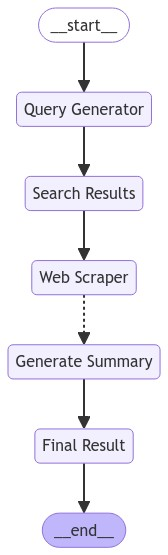

In [49]:
from IPython.display import Image, display

try:
    display(Image(perplexity_clone_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
import random
import string

def generate_random_alphanumeric(length=4):
  characters = string.ascii_letters + string.digits
  result = ''.join(random.choice(characters) for i in range(length))
  return result

query_id = generate_random_alphanumeric()
print(query_id)

OZMx


In [65]:
config = {"configurable": {"thread_id": f'{query_id}'},"recursion_limit": 20}

In [66]:
from langchain_core.messages import BaseMessage, HumanMessage
inputs = {
    "messages": [HumanMessage(content="Create a quick start guide for langGraph")],
}

In [67]:
output=perplexity_clone_graph.invoke(inputs, config)

Fetching pages: 100%|##########| 6/6 [00:01<00:00,  4.99it/s]


In [68]:
print(output)

{'messages': [HumanMessage(content='Create a quick start guide for langGraph'), AIMessage(content='Here\'s a quick start guide for LangGraph based on the provided context:\n\n1. What is LangGraph?\nLangGraph is a library for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain Expression Language to coordinate multiple chains or actors across multiple steps of computation in a cyclic manner. (Source: https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383)\n\n2. Key Features:\n- Graph-based data structures\n- Functional programming\n- Type-safe\n- Dynamic typing (optional)\n- Integration with popular libraries\n(Source: https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383)\n\n3. Installation:\n```bash\npip install langgraph\n```\n(Source: https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9)\n\n4. Key Concepts:\n- Stat

In [69]:
from IPython.display import Markdown, display
display(Markdown(output['messages'][-1].content))

Here's a quick start guide for LangGraph based on the provided context:

1. What is LangGraph?
LangGraph is a library for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain Expression Language to coordinate multiple chains or actors across multiple steps of computation in a cyclic manner. (Source: https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383)

2. Key Features:
- Graph-based data structures
- Functional programming
- Type-safe
- Dynamic typing (optional)
- Integration with popular libraries
(Source: https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383)

3. Installation:
```bash
pip install langgraph
```
(Source: https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9)

4. Key Concepts:
- StateGraph: The main structure that maps how your AI moves from one task to another.
- Nodes: Individual tasks or actions in your AI workflow.
- Edges: Connections between nodes that define the flow of tasks.
- State: Memory that keeps track of information as the AI moves through tasks.
- Conditional Edges: Allow dynamic routing based on the current state or output of a node.
(Source: https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9)

5. Basic Usage:
a. Define the Graph State:
```python
from typing import Dict, TypedDict, Optional
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None
```

b. Create the Graph:
```python
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)
```

c. Define Nodes:
```python
def classify_input_node(state):
    # Your node logic here
    return {"classification": classification}

def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}
```

d. Add Nodes to the Graph:
```python
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
```

e. Set Entry and End Points:
```python
workflow.set_entry_point("classify_input")
workflow.add_edge('handle_greeting', END)
```

f. Compile and Run the Graph:
```python
app = workflow.compile()
inputs = {"question": "Hello, how are you?"}
result = app.invoke(inputs)
print(result)
```
(Source: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141)

6. Resources for Learning:
- LangGraph Official Documentation: https://langchain-ai.github.io/langgraph/
- Official YouTube Playlist: https://www.youtube.com/watch?v=5h-JBkySK34&list=PLfaIDFEXuae16n2TWUkKq5PgJ0w6Pkwtg
- Examples Repository: https://github.com/langchain-ai/langgraph/tree/main/examples
(Source: https://medium.com/@gopiariv/langgraph-a-beginners-guide-to-building-ai-workflows-e500965f2ef9)

This quick start guide should help you get started with LangGraph. For more detailed information and advanced usage, refer to the official documentation and resources provided.